# Topic Modeling - Latent Dirichlet Allocation (LDA) Using Gensim

In [54]:
import pandas as pd
import numpy as np
import re
import tqdm

import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for Lemmatization
import spacy

#Plotting Tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt


In [55]:
df = pd.read_csv('data/BBC-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [56]:
df.shape

(2225, 2)

### Data Processing

In [57]:
# Convert to List
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\s*@\S*\s?', '', i) for i in data]

# Remove new line characters
data = [re.sub('\s+', ' ', i) for i in data]


# Remove distracting single quotes
data = [re.sub("\'", "", i) for i in data]

### Tokenize Words and Clean-up Text

In [58]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'ha

### Remove Stopwords and Lemmatize Tokens

In [59]:
# NLTK Stop Words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [60]:
# Spacy Lemmatization
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmentization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

# Do Lemmentization keeping only nouns
data_lemmentized = lemmentization(data_words_nostops, allowed_postags=['NOUN'])

In [61]:
print(data_lemmentized[:2])

[['tv', 'viewer', 'home', 'theatre', 'system', 'definition', 'video', 'recorder', 'living', 'room', 'way', 'people', 'tv', 'year', 'time', 'expert', 'panel', 'consumer', 'electronic', 'show', 'technology', 'impact', 'pastime', 'trend', 'programme', 'content', 'viewer', 'home', 'network', 'cable', 'satellite', 'telecom', 'company', 'service', 'provider', 'room', 'device', 'technology', 'video', 'recorder', 'dvr', 'box', 'sky', 'system', 'people', 'record', 'store', 'pause', 'wind', 'tv', 'programme', 'technology', 'tv', 'definition', 'tv', 'business', 'definition', 'programming', 'people', 'wind', 'advert', 'network', 'channel', 'schedule', 'carte', 'network', 'cable', 'satellite', 'company', 'term', 'advertising', 'revenue', 'brand', 'identity', 'viewer', 'loyalty', 'channel', 'technology', 'moment', 'concern', 'uptake', 'service', 'sky', 'today', 'month', 'year', 'futurologist', 'news', 'website', 'issue', 'advertising', 'revenue', 'issue', 'moment', 'brand', 'loyalty', 'content', 'br

### Latent Dirichlet ALlocation (LDA) Model

In [62]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmentized)
print(id2word)

# Create Corpus
texts = data_lemmentized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Dictionary<113 unique tokens: ['advert', 'advertising', 'bill', 'book', 'box']...>


### Creating a Base Model

In [63]:
# baseline model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=100,
                                            chunksize=200,
                                            passes=10,
                                            per_word_topics=True)   

In [64]:
# Print the Keyword in the 5 Topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.009*"tv" + 0.009*"people" + 0.009*"channel" + 0.009*"definition" + 0.009*"brand" + 0.009*"programme" + 0.009*"satellite" + 0.009*"technology" + 0.009*"content" + 0.009*"viewer"'), (1, '0.010*"tv" + 0.009*"people" + 0.009*"brand" + 0.009*"viewer" + 0.009*"network" + 0.009*"technology" + 0.009*"dvr" + 0.009*"channel" + 0.009*"definition" + 0.009*"recorder"'), (2, '0.010*"tv" + 0.009*"people" + 0.009*"channel" + 0.009*"brand" + 0.009*"technology" + 0.009*"viewer" + 0.009*"definition" + 0.009*"dvr" + 0.009*"network" + 0.009*"satellite"'), (3, '0.010*"tv" + 0.009*"brand" + 0.009*"network" + 0.009*"people" + 0.009*"technology" + 0.009*"channel" + 0.009*"content" + 0.009*"definition" + 0.009*"viewer" + 0.009*"programme"'), (4, '0.055*"tv" + 0.032*"people" + 0.023*"technology" + 0.023*"network" + 0.023*"channel" + 0.023*"brand" + 0.019*"programme" + 0.019*"content" + 0.019*"definition" + 0.019*"viewer"')]


### How Good a Given Topic Model Is? - Topic Cohrerence

In [65]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmentized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41045705733537946


### Model Improvement

In [66]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various numbers of topics

    Parameters:
    -----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: List of input texts
    limit: Max number of topics

    Returns:
    -------
    model_list = List of LDA topic models
    coherence_values: Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, random_state=100, 
                                                chunksize=200, passes=10, per_word_topics=True, id2word=id2word)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [67]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmentized,
                                                        start=2, limit=8, step=1)

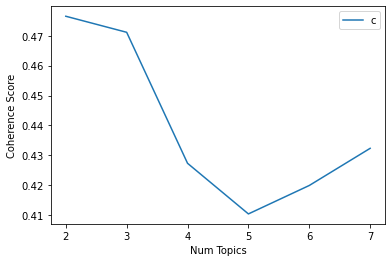

In [68]:
# Show graph
limit=8; start=2; step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.legend(("coherence_values"), loc='best')
plt.show()

In [69]:
# Print the Coherence Scores
for m, cv in zip(x, coherence_values):
    print("Num Topics = ", m, " has Coherence Value of ", round(cv, 4))

Num Topics =  2  has Coherence Value of  0.4765
Num Topics =  3  has Coherence Value of  0.4711
Num Topics =  4  has Coherence Value of  0.4274
Num Topics =  5  has Coherence Value of  0.4105
Num Topics =  6  has Coherence Value of  0.42
Num Topics =  7  has Coherence Value of  0.4324


In [70]:
# Supporting Function
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=5,
                                                random_state=100,
                                                chunksize=200,
                                                passes=10,
                                                alpha= a,
                                                eta= b,
                                                per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmentized, dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [71]:
grid = {}
grid['Validation_Set'] = {}

# Topics Range
min_topics = 2
max_topics = 7
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha Parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta Parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [72]:
# Validation Sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                'Topics': [],
                'Alpha': [],
                'Beta': [],
                'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=540)

    for i in range(len(corpus_sets)):
        #iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterate through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
                                                k=k, a=a, b=b)
                    
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_new.csv', index=False)
    pbar.close()

 56%|█████▌    | 300/540 [02:34<02:03,  1.94it/s]


In [73]:
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=5,
                                                random_state=100,
                                                chunksize=200,
                                                passes=10,
                                                alpha= 0.01,
                                                eta= 'symmetric',
                                                per_word_topics=True)

# passes: Number of passes through the entire corpus
# chunksize: Number of documents to load into memory at a time and process E steps of EM

In [74]:
coherence_model_lda = CoherenceModel(model=lda_model_final, texts =data_lemmentized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4294974730689459


### Visualize the Topics Keywords

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

### Topic Distribution Across Documents

In [75]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init ouput
    sent_topics_df = pd.DataFrame()

    # Get Main Topic From Each Document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and kewords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                series = pd.Series([int(topic_num), round(prop_topic,4), topic_keywords])
                sent_topics_df = sent_topics_df.append(series, ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original tect to the end of the output
    content = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, content], axis=1)
    return(sent_topics_df)

In [76]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=data)

/var/folders/5m/l4wdc7bs25b7d_ztg1721x6w0000gn/T/ipykernel_1193/818713336.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(series, ignore_index=True)


In [77]:
df_topic_distribution = df_topic_sents_keywords['Dominant_Topic'].value_counts().reset_index(name='Num Documents')
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']
df_topic_distribution.sort_values('Dominant_Topic')

,Dominant_Topic,Num Documents
0,4.0,1


### Visualize Topics - Wordcloud of Top N Words in Each Topic

In [78]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [81]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                background_color='white',
                width=2500,
                height=2800,
                max_words=15,
                colormap='tab10',
                color_func=lambda *args, **kwargs: cols[i],
                prefer_horizontal=1.0)

topics = lda_model_final.show_topics(formatted=False)
topics

[(0,
  [('tv', 0.009044955),
   ('people', 0.008918709),
   ('channel', 0.008913487),
   ('definition', 0.008906995),
   ('brand', 0.008906917),
   ('programme', 0.008904705),
   ('satellite', 0.008900909),
   ('technology', 0.008897818),
   ('viewer', 0.008883702),
   ('content', 0.008883348)]),
 (1,
  [('tv', 0.009598294),
   ('people', 0.009170193),
   ('brand', 0.00903329),
   ('viewer', 0.009008655),
   ('network', 0.008994131),
   ('technology', 0.008978104),
   ('dvr', 0.008975246),
   ('channel', 0.008967553),
   ('definition', 0.008959085),
   ('recorder', 0.008952822)]),
 (2,
  [('tv', 0.009495398),
   ('people', 0.009154245),
   ('channel', 0.009076135),
   ('brand', 0.009066988),
   ('technology', 0.009012337),
   ('viewer', 0.009004636),
   ('definition', 0.008971803),
   ('dvr', 0.00896423),
   ('network', 0.008950607),
   ('satellite', 0.008948871)]),
 (3,
  [('tv', 0.009716896),
   ('brand', 0.009248397),
   ('network', 0.009219445),
   ('people', 0.009163496),
   ('tec

IndexError: list index out of range

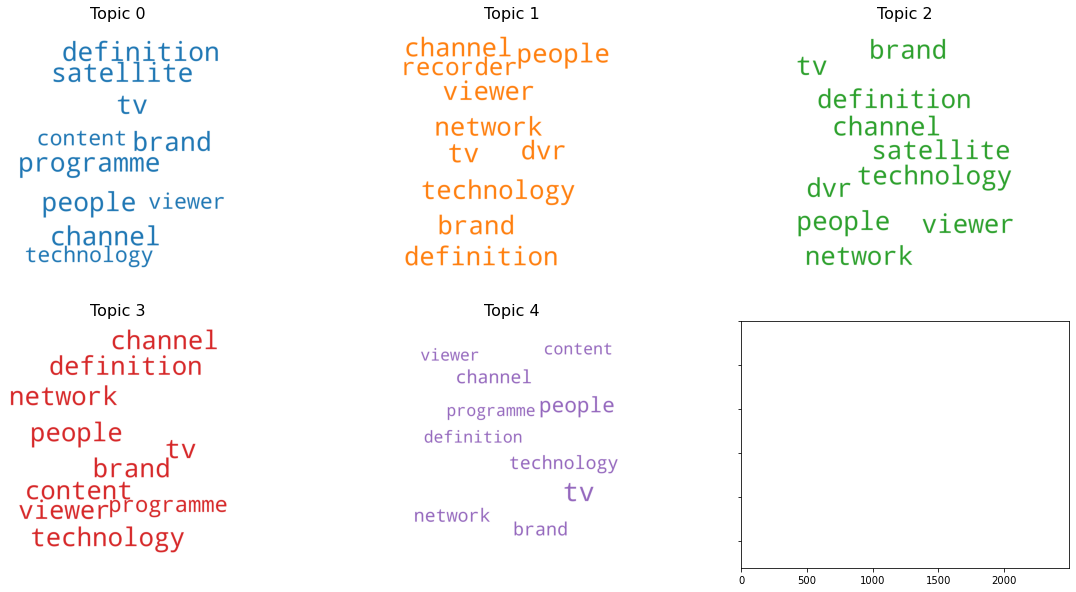

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0,y=0)
plt.tight_layout()
plt.show()